#fMRI MaskGNN Model Building

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy import stats
from nilearn.connectome import ConnectivityMeasure
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GATConv, GCNConv, GraphConv, SAGEConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.utils import dropout_adj
import tqdm


## Load Data

In [5]:
pheno = pd.read_csv('./Phenotypic_V1_0b_preprocessed1.csv')

# Delete first row as specified
pheno = pheno.iloc[1:].reset_index(drop=True)

print("Dataset Overview:")
print(f"Total subjects: {len(pheno)}")
print(f"Columns: {pheno.columns.tolist()}")
print("\nFirst few rows:")
pheno.head()
# pheno = pheno.sample(n=50)

class ASDFMRIPreprocessor:
    def __init__(self, atlas_name='cc200'):
        self.atlas_name = atlas_name
        self.scaler = StandardScaler()
        self.loaded_subjects = {}
        
    def load_roi_timeseries(self, sub_id, roits_dir="./fmri_roits/"):
        """Enhanced ROI timeseries loading with quality checks"""
        if sub_id in self.loaded_subjects:
            return self.loaded_subjects[sub_id]
            
        filepath = os.path.join(roits_dir, f"{sub_id}_rois_{self.atlas_name}.1D")
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File not found: {filepath}")
            
        ts = np.loadtxt(filepath)
        
        # Quality checks
        if ts.shape[1] != 200:  # CC200 should have 200 ROIs
            raise ValueError(f"Expected 200 ROIs, got {ts.shape[1]} for {sub_id}")
            
        # Check for excessive motion or artifacts
        if np.any(np.isnan(ts)) or np.any(np.isinf(ts)):
            print(f"Warning: NaN/Inf values found in {sub_id}")
            ts = np.nan_to_num(ts)
            
        # Store in cache
        self.loaded_subjects[sub_id] = ts
        return ts
    
    def compute_enhanced_connectivity(self, ts, method='correlation'):
        """Compute enhanced connectivity matrices"""
        conn_measure = ConnectivityMeasure(
            kind=method,
            standardize=True,
            discard_diagonal=True
        )
        
        conn_matrix = conn_measure.fit_transform([ts])[0]
        
        # Fisher z-transformation for normalization
        conn_matrix = np.arctanh(np.clip(conn_matrix, -0.999, 0.999))
        
        return conn_matrix
    
    def extract_network_features(self, ts):
        """Extract ASD-relevant network features - ENHANCED VERSION"""
        features = {}
        
        # Original temporal features
        features['temporal_mean'] = np.mean(ts, axis=0)
        features['temporal_std'] = np.std(ts, axis=0)
        features['temporal_skew'] = stats.skew(ts, axis=0)
        features['temporal_kurt'] = stats.kurtosis(ts, axis=0)
        
        # Enhanced connectivity features
        conn_matrix = self.compute_enhanced_connectivity(ts)
        
        # Standard network metrics
        G = nx.from_numpy_array(np.abs(conn_matrix))
        
        features['clustering'] = np.array(list(nx.clustering(G).values()))
        features['betweenness'] = np.array(list(nx.betweenness_centrality(G).values()))
        features['closeness'] = np.array(list(nx.closeness_centrality(G).values()))
        features['degree'] = np.array(list(dict(G.degree()).values()))
        
        # NEW ASD-SPECIFIC FEATURES
        # 1. Local efficiency (important for ASD)
        features['local_efficiency'] = self.compute_local_efficiency(G)
        
        # 2. Participation coefficient (network integration)
        features['participation_coeff'] = self.compute_participation_coefficient(conn_matrix)
        
        # 3. Temporal variability (ASD shows altered dynamics)
        features['temporal_variability'] = np.var(ts, axis=0) / (np.mean(np.abs(ts), axis=0) + 1e-8)
        
        # 4. Frequency band features
        freq_features = self.extract_frequency_features(ts)
        features.update(freq_features)
        
        # 5. Spectral features
        fft_ts = np.fft.fft(ts, axis=0)
        features['spectral_power'] = np.mean(np.abs(fft_ts)**2, axis=0)
        
        return features, conn_matrix
    
    def compute_local_efficiency(self, G):
        """Compute local efficiency for each node"""
        local_eff = np.zeros(G.number_of_nodes())
        for i, node in enumerate(G.nodes()):
            neighbors = list(G.neighbors(node))
            if len(neighbors) > 1:
                subgraph = G.subgraph(neighbors)
                if subgraph.number_of_edges() > 0:
                    # Simplified local efficiency calculation
                    local_eff[i] = nx.global_efficiency(subgraph)
                else:
                    local_eff[i] = 0
            else:
                local_eff[i] = 0
        return local_eff
    
    def compute_participation_coefficient(self, conn_matrix, n_modules=5):
        """Compute participation coefficient for network integration"""
        try:
            from sklearn.cluster import SpectralClustering
            
            # Simple module assignment
            clustering = SpectralClustering(n_clusters=n_modules, random_state=42)
            modules = clustering.fit_predict(np.abs(conn_matrix))
            
            n_nodes = conn_matrix.shape[0]
            participation = np.zeros(n_nodes)
            
            for i in range(n_nodes):
                node_strength = np.sum(np.abs(conn_matrix[i, :]))
                if node_strength == 0:
                    participation[i] = 0
                    continue
                    
                within_module_strength = 0
                for j in range(n_nodes):
                    if modules[i] == modules[j]:
                        within_module_strength += np.abs(conn_matrix[i, j])
                
                participation[i] = 1 - (within_module_strength / node_strength) ** 2
                
            return participation
        except:
            # Fallback if spectral clustering fails
            return np.random.rand(conn_matrix.shape[0]) * 0.1
    
    def extract_frequency_features(self, ts):
        """Extract frequency domain features relevant to ASD"""
        features = {}
        
        # Simple frequency analysis
        fft_data = np.fft.fft(ts, axis=0)
        freqs = np.fft.fftfreq(ts.shape[0])
        power_spectrum = np.abs(fft_data) ** 2
        
        # Low frequency power (0-25% of frequency range)
        low_freq_mask = np.abs(freqs) <= 0.25 * np.max(np.abs(freqs))
        features['low_freq_power'] = np.mean(power_spectrum[low_freq_mask, :], axis=0)
        
        # High frequency power (25%-50% of frequency range) 
        high_freq_mask = (np.abs(freqs) > 0.25 * np.max(np.abs(freqs))) & (np.abs(freqs) <= 0.5 * np.max(np.abs(freqs)))
        features['high_freq_power'] = np.mean(power_spectrum[high_freq_mask, :], axis=0)
        
        return features

# Initialize the enhanced preprocessor
preprocessor = ASDFMRIPreprocessor()
print("preprocessor initialized successfully!")

print("Loading all subjects...")

all_data = {}
all_labels = {}
failed_subjects = []

# Get all subjects from phenotypic data
all_subjects = pheno['FILE_ID'].dropna().unique()
print(f"Total subjects to process: {len(all_subjects)}")

for sub_id in tqdm.tqdm(all_subjects, desc="Loading all subjects"):
    try:
        # Get label and other info
        subject_row = pheno[pheno['FILE_ID'] == sub_id]
        if subject_row.empty:
            continue
            
        dx = subject_row['DX_GROUP'].iloc[0]
        if dx not in [1, 2]:
            continue
            
        # Load timeseries
        ts = preprocessor.load_roi_timeseries(sub_id)
        
        # Extract features
        features, conn_matrix = preprocessor.extract_network_features(ts)
        
        all_data[sub_id] = {
            'timeseries': ts,
            'features': features,
            'connectivity': conn_matrix,
            'age': subject_row['AGE_AT_SCAN'].iloc[0],
            'site': subject_row['SITE_ID'].iloc[0],
            'sex': subject_row['SEX'].iloc[0]
        }
        
        all_labels[sub_id] = 1 if dx == 1 else 0  # 1 for ASD, 0 for Control
        
    except Exception as e:
        failed_subjects.append((sub_id, str(e)))
        continue

print(f"Successfully loaded {len(all_data)} subjects")
print(f"Failed to load {len(failed_subjects)} subjects")
print(f"Final labels: {Counter(all_labels.values())}")

# Show some failed subjects for debugging
if failed_subjects:
    print("\nSample failed subjects:")
    for sub_id, error in failed_subjects[:5]:
        print(f"  {sub_id}: {error}")


Dataset Overview:
Total subjects: 1111
Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'SUB_ID', 'X', 'subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX', 'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ', 'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE', 'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE', 'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV', 'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB', 'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION', 'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION', 'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL', 'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME', 'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED', 'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED', 'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_SCALED', 'VINELAND_DOMESTIC

Loading all subjects:   0%|          | 0/1036 [00:00<?, ?it/s]/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/sklearn/cluster/_spectral.py:706: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Loading all subjects:   0%|          | 1/1036 [00:08<2:31:46,  8.80s/it]/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/sklearn/cluster/_spectral.py:706: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
Loading all subjects:   0%|          | 2/1036 [00:15<2:10:51,  7.59s/it]/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/sklearn/cluster/_spectral.py:706: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a cust

Successfully loaded 1035 subjects
Failed to load 1 subjects
Final labels: Counter({0: 530, 1: 505})

Sample failed subjects:
  no_filename: File not found: ./fmri_roits/no_filename_rois_cc200.1D


## Develop Static Connectivity Matrix

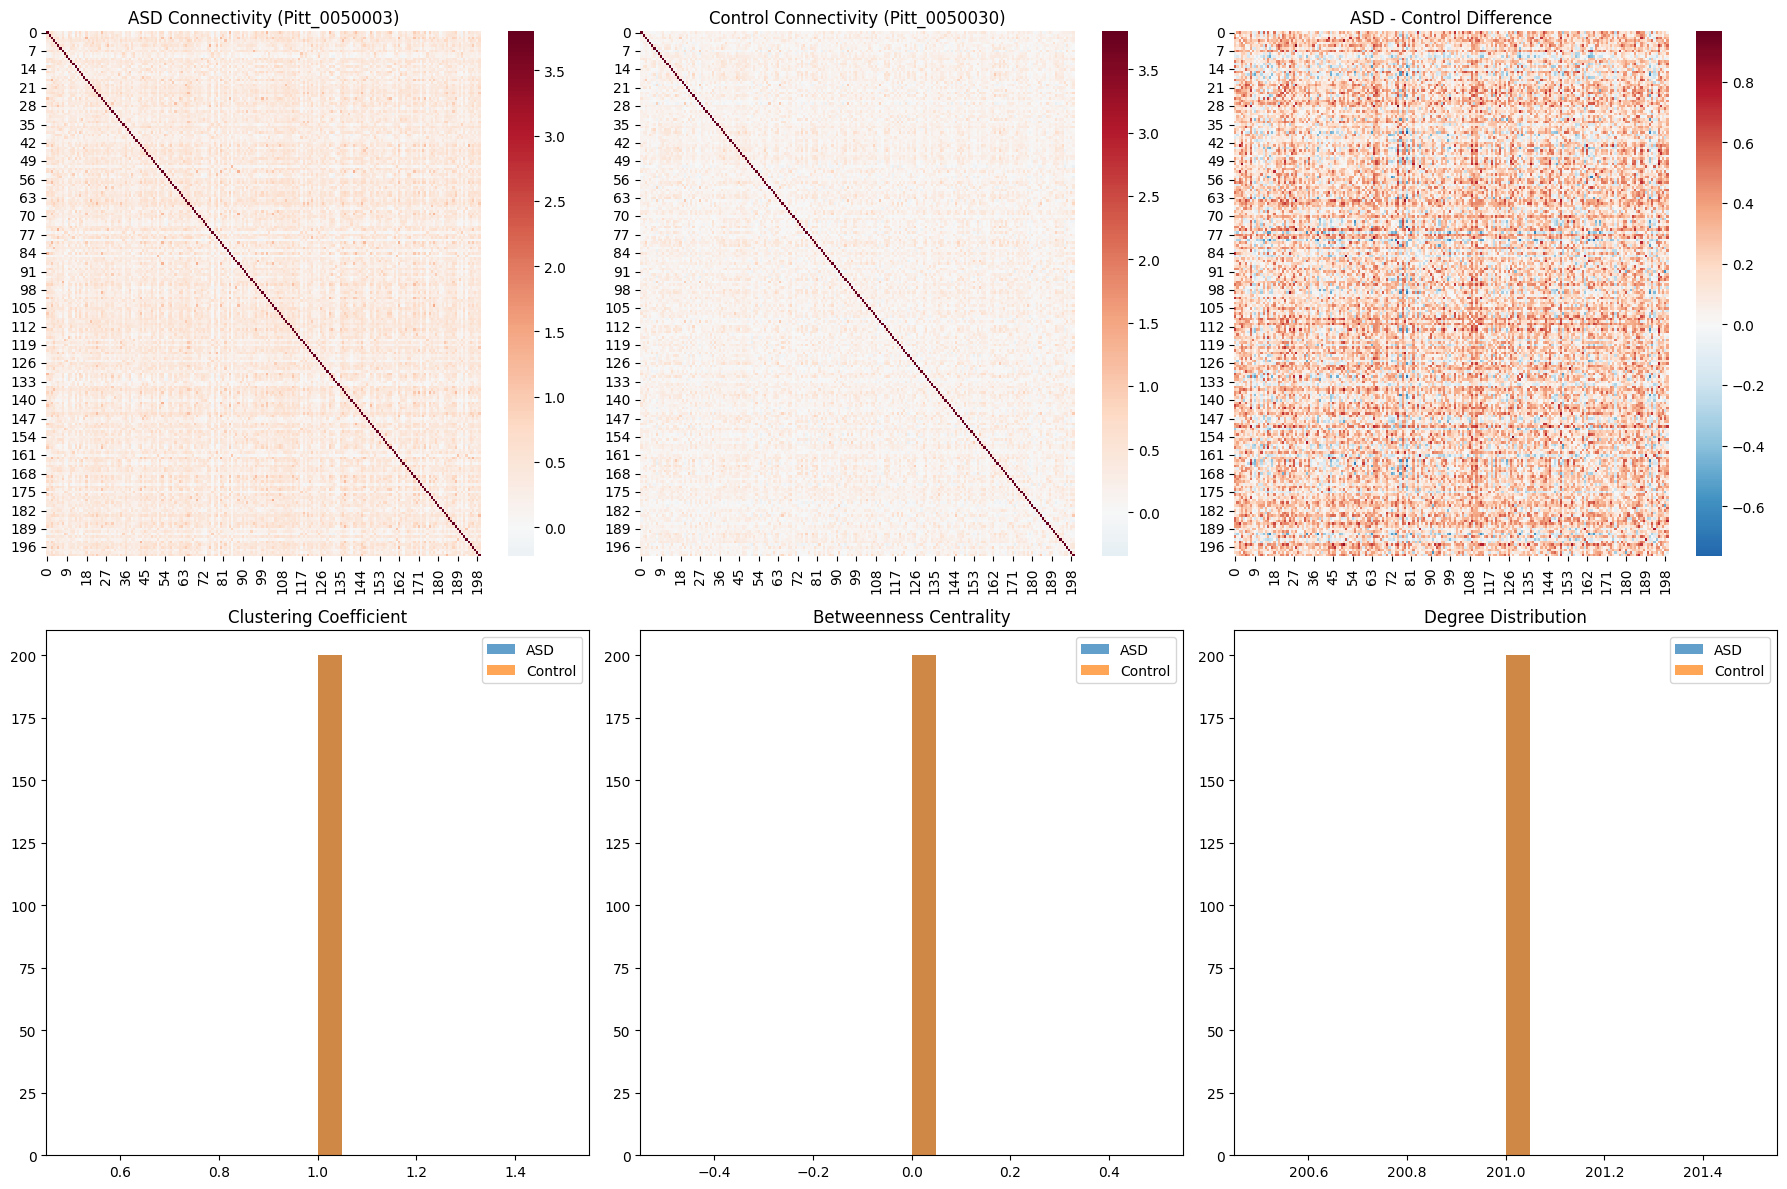

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Get one ASD and one control subject
asd_subjects = [k for k, v in all_labels.items() if v == 1]
control_subjects = [k for k, v in all_labels.items() if v == 0]

if len(asd_subjects) > 0 and len(control_subjects) > 0:
    asd_sub = asd_subjects[0]
    control_sub = control_subjects[0]
    
    # Plot connectivity matrices
    sns.heatmap(all_data[asd_sub]['connectivity'], 
                cmap='RdBu_r', center=0, ax=axes[0,0], cbar=True)
    axes[0,0].set_title(f'ASD Connectivity ({asd_sub})')
    
    sns.heatmap(all_data[control_sub]['connectivity'], 
                cmap='RdBu_r', center=0, ax=axes[0,1], cbar=True)
    axes[0,1].set_title(f'Control Connectivity ({control_sub})')
    
    # Plot difference
    diff_matrix = all_data[asd_sub]['connectivity'] - all_data[control_sub]['connectivity']
    sns.heatmap(diff_matrix, cmap='RdBu_r', center=0, ax=axes[0,2], cbar=True)
    axes[0,2].set_title('ASD - Control Difference')
    
    # Plot feature distributions
    features_asd = all_data[asd_sub]['features']
    features_control = all_data[control_sub]['features']
    
    # Clustering coefficient
    axes[1,0].hist(features_asd['clustering'], alpha=0.7, label='ASD', bins=20)
    axes[1,0].hist(features_control['clustering'], alpha=0.7, label='Control', bins=20)
    axes[1,0].set_title('Clustering Coefficient')
    axes[1,0].legend()
    
    # Betweenness centrality
    axes[1,1].hist(features_asd['betweenness'], alpha=0.7, label='ASD', bins=20)
    axes[1,1].hist(features_control['betweenness'], alpha=0.7, label='Control', bins=20)
    axes[1,1].set_title('Betweenness Centrality')
    axes[1,1].legend()
    
    # Degree distribution
    axes[1,2].hist(features_asd['degree'], alpha=0.7, label='ASD', bins=20)
    axes[1,2].hist(features_control['degree'], alpha=0.7, label='Control', bins=20)
    axes[1,2].set_title('Degree Distribution')
    axes[1,2].legend()

plt.tight_layout()
plt.show()

## Build Graphs from Connectivity Matrices

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
from torch_geometric.data import Data
import numpy as np

class ASDGraphBuilder:
    def __init__(self, threshold_method='adaptive', edge_density=0.15):
        self.threshold_method = threshold_method
        self.edge_density = edge_density
        #self.pca = PCA(n_components=10)

    def build_adaptive_graph(self, conn_matrix, features, label):
        N = conn_matrix.shape[0]
        conn_min = np.min(conn_matrix)
        conn_max = np.max(conn_matrix)

        conn_matrix_norm = (conn_matrix - conn_min) / (conn_max - conn_min) if conn_max > conn_min else np.zeros_like(conn_matrix)
        threshold = np.percentile(conn_matrix_norm, (1 - self.edge_density) * 100) if self.threshold_method == 'adaptive' else 0.5

        adj_matrix = conn_matrix_norm > threshold
        np.fill_diagonal(adj_matrix, 0)
        if np.sum(adj_matrix) < N * 2:
            threshold = np.percentile(conn_matrix_norm, 85)
            adj_matrix = conn_matrix_norm > threshold
            np.fill_diagonal(adj_matrix, 0)

        edge_indices = np.where(adj_matrix)
        edge_index = torch.tensor(np.vstack(edge_indices), dtype=torch.long)
        edge_weights = torch.tensor(conn_matrix_norm[edge_indices], dtype=torch.float32)

        node_features_list = [
            features['temporal_mean'],
            features['temporal_std'],
            features['clustering'],
            features['betweenness'],
            features['closeness'],
            features['degree'] / N
        ]

        if 'local_efficiency' in features:
            node_features_list.extend([
                features['local_efficiency'],
                features['participation_coeff'],
                features['temporal_variability'],
                features['low_freq_power'],
                features['high_freq_power'],
                features['spectral_power']
            ])

        node_features = np.column_stack(node_features_list)
        node_features = StandardScaler().fit_transform(node_features)
        #node_features = self.pca.fit_transform(node_features)  # Reduce to 6 features

        x = torch.tensor(node_features, dtype=torch.float32)
        y = torch.tensor([label], dtype=torch.long)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_weights, y=y)
    
graph_builder = ASDGraphBuilder(threshold_method='adaptive', edge_density=0.15)

engineered_fMRI = {}  # new dict for saving features

all_graphs = []
for sub_id in tqdm.tqdm(all_data.keys(), desc="Building normalized graphs"):
    try:
        # === 1. Build the 12 engineered features (before PCA) ===
        features = all_data[sub_id]['features']
        node_features_list = [
            features['temporal_mean'],
            features['temporal_std'],
            features['clustering'],
            features['betweenness'],
            features['closeness'],
            features['degree'] / len(features['degree'])
        ]

        if 'local_efficiency' in features:
            node_features_list.extend([
                features['local_efficiency'],
                features['participation_coeff'],
                features['temporal_variability'],
                features['low_freq_power'],
                features['high_freq_power'],
                features['spectral_power']
            ])

        # Save raw engineered features (shape: [num_nodes, 12])
        engineered_fMRI[sub_id] = np.column_stack(node_features_list)

        # === 2. Build the graph using existing graph builder (with PCA) ===
        graph = graph_builder.build_adaptive_graph(
            all_data[sub_id]['connectivity'],
            all_data[sub_id]['features'],
            all_labels[sub_id]
        )

        all_graphs.append(graph)

    except Exception as e:
        print(f"Error building graph for {sub_id}: {e}")

import pickle
with open("engineered_fMRI.pkl", "wb") as f:
    pickle.dump(engineered_fMRI, f)

print(f"✅ Saved engineered_fMRI with {len(engineered_fMRI)} subjects. "
      f"Example shape: {next(iter(engineered_fMRI.values())).shape}")

Building normalized graphs: 100%|██████████| 1035/1035 [00:02<00:00, 452.57it/s]

✅ Saved engineered_fMRI with 1035 subjects. Example shape: (200, 12)


## fMRI GATConv Model Pipeline

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device type: {type(device)}")
print(f"Device: {device}")


class ASDMaskGNN(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=48, num_classes=2, dropout=0.3, node_mask_rate=0.1, edge_mask_rate=0.05,feature_mask_rate=0.15):
        super(ASDMaskGNN, self).__init__()

        # GNN Layers
        self.conv1 = GATConv(input_dim, hidden_dim, heads=2, concat=True)
        self.conv2 = GATConv(hidden_dim * 2, hidden_dim, heads=2, concat=True)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim)
        self.conv4 = SAGEConv(hidden_dim, hidden_dim)

        # Residual Connections
        self.residual1 = nn.Linear(input_dim, hidden_dim * 2)
        self.residual2 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.residual3 = nn.Linear(hidden_dim * 2, hidden_dim)

        # Normalization
        self.ln1 = nn.LayerNorm(hidden_dim * 2)
        self.ln2 = nn.LayerNorm(hidden_dim * 2)
        self.ln3 = nn.LayerNorm(hidden_dim)
        self.ln4 = nn.LayerNorm(hidden_dim)

        # Attention for node importance
        self.mask_attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

        self.dropout_layer = nn.Dropout(dropout)

        # Learnable node mask token (used after GNN layers)
        self.node_mask_token = nn.Parameter(torch.zeros(hidden_dim))
        self.node_mask_rate = 0.1

    def apply_node_masking(self, x, batch):
        if not self.training:
            return x
        new_x = x.clone()
        for graph_id in torch.unique(batch):
            graph_nodes = (batch == graph_id)
            num_nodes = graph_nodes.sum().item()
            num_masked = int(num_nodes * self.node_mask_rate)
            if num_masked > 0:
                graph_indices = torch.where(graph_nodes)[0]
                mask_indices = graph_indices[torch.randperm(len(graph_indices))[:num_masked]]
                new_x[mask_indices] = self.node_mask_token
        return new_x

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Forward pass through GNN layers
        h1 = self.conv1(x, edge_index)
        h1 = h1 + self.residual1(x)
        h1 = self.ln1(h1)
        h1 = F.elu(h1)
        h1 = self.dropout_layer(h1)

        h2 = self.conv2(h1, edge_index)
        h2 = h2 + self.residual2(h1)
        h2 = self.ln2(h2)
        h2 = F.elu(h2)
        h2 = self.dropout_layer(h2)

        h3 = self.conv3(h2, edge_index)
        h3 = h3 + self.residual3(h2)
        h3 = self.ln3(h3)
        h3 = F.elu(h3)
        h3 = self.dropout_layer(h3)

        h4 = self.conv4(h3, edge_index)
        h4 = self.ln4(h4)
        h4 = F.elu(h4)
        h4 = self.dropout_layer(h4)

        # Apply masking AFTER representation learning
        h4_masked = self.apply_node_masking(h4, batch)

        attention_weights = self.mask_attention(h4_masked)
        h_weighted = h4_masked * attention_weights

        h_mean = global_mean_pool(h_weighted, batch)
        h_max = global_max_pool(h_weighted, batch)
        h_sum = global_add_pool(h_weighted, batch)

        h_combined = torch.cat([h_mean, h_max, h_sum], dim=1)
        out = self.classifier(h_combined)

        return F.log_softmax(out, dim=1)


input_dim = 10
# Initialize model
if len(all_graphs) > 0:
    input_dim = all_graphs[0].x.shape[1]
    model = ASDMaskGNN(
    input_dim=input_dim,
    hidden_dim=48,
    dropout=0.3,
    node_mask_rate=0.1,
    edge_mask_rate=0.05,
    feature_mask_rate=0.15
)
    model = model.to(device)
    
    print(f"Model initialized with input dimension: {input_dim}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Device type: <class 'torch.device'>
Device: cpu
Model initialized with input dimension: 12
Model parameters: 44,355


## Train Model

In [10]:

from sklearn.metrics import accuracy_score


class FocalLoss(nn.Module):
    """Focal loss to handle class imbalance and hard examples"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class ASDTrainer:
    def __init__(self, model, device, learning_rate=0.0005, weight_decay=1e-4, 
                 use_focal_loss=False, class_weights=None):
        self.model = model.to(device)
        self.device = device

        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.8, patience=5
        )

        if class_weights is not None:
            class_weights = np.array(class_weights)
            class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
            print(f"Using softened class weights: {class_weights.cpu().numpy()}")
        else:
            self.criterion = nn.CrossEntropyLoss()

        if use_focal_loss:
            print("Note: Focal loss disabled for stability - using CrossEntropyLoss")

        self.train_losses = []
        self.train_accs = []
        self.val_accs = []
        self.val_aucs = []

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss, correct = 0, 0

        for batch in train_loader:
            batch = batch.to(self.device)
            self.optimizer.zero_grad()
            out = self.model(batch)
            loss = self.criterion(out, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
            self.optimizer.step()

            total_loss += loss.item() * batch.num_graphs
            pred = out.argmax(dim=1)
            correct += int((pred == batch.y).sum())

        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = correct / len(train_loader.dataset)

        self.train_losses.append(avg_loss)
        self.train_accs.append(accuracy)

        return avg_loss, accuracy

    def evaluate(self, loader):
        self.model.eval()
        y_true, y_pred, y_proba = [], [], []

        with torch.no_grad():
            for batch in loader:
                batch = batch.to(self.device)
                out = self.model(batch)
                pred = out.argmax(dim=1)
                proba = F.softmax(out, dim=1)
                y_true.extend(batch.y.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())
                y_proba.extend(proba.cpu().numpy())

        acc = accuracy_score(y_true, y_pred)
        try:
            auc = roc_auc_score(y_true, np.array(y_proba)[:, 1])
        except ValueError:
            auc = 0.5

        self.val_accs.append(acc)
        self.val_aucs.append(auc)

        return acc, auc, y_true, y_pred, y_proba

    def train(self, train_loader, val_loader=None, epochs=50, patience=10):
        best_auc = 0
        patience_counter = 0

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_acc, val_auc, *_ = self.evaluate(val_loader or train_loader)
            self.scheduler.step(val_auc)

            if val_auc > best_auc:
                best_auc = val_auc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            if epoch % 5 == 0:
                print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")

    def predict(self, loader):
        self.model.eval()
        y_true, y_proba = [], []

        with torch.no_grad():
            for batch in loader:
                batch = batch.to(self.device)
                out = self.model(batch)
                proba = F.softmax(out, dim=1)
                y_true.extend(batch.y.cpu().numpy())
                y_proba.extend(proba.cpu().numpy())

        return y_true, y_proba

## Sensitivity/Specificity mismatch debug

In [11]:
from sklearn.model_selection import train_test_split


class BalancedTrainer(ASDTrainer):
    def __init__(self, model, device, learning_rate=0.0005, weight_decay=1e-4):
        super().__init__(model, device, learning_rate, weight_decay)
        
        # Use MILD class weights (closer to 1.0)
        # Instead of extreme weights like [1.33, 0.8], use gentle ones
        mild_weights = torch.tensor([1.1, 0.9], dtype=torch.float32).to(device)
        self.criterion = nn.CrossEntropyLoss(weight=mild_weights)


## Cross Validation Training

In [12]:
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score
from sklearn.utils import compute_class_weight


def run_cross_validation(graphs, num_folds=5, input_dim=12, hidden_dim=128, dropout=0.3):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    labels = np.array([g.y.item() for g in graphs])
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(graphs, labels)):
        print(f"\n--- Fold {fold + 1} ---")
        train_graphs = [graphs[i] for i in train_idx]
        test_graphs = [graphs[i] for i in test_idx]

        train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)

        model = ASDMaskGNN(input_dim=input_dim, hidden_dim=hidden_dim, dropout=dropout).to(device)
        trainer = ASDTrainer(model, device)
        trainer.train(train_loader, val_loader=test_loader, epochs=50)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': trainer.optimizer.state_dict(),
        }, f'best_model_fold_{fold + 1}.pt')

        # Get predictions and probabilities
        y_true, y_proba = trainer.predict(test_loader)
        y_proba = np.array(y_proba)

        # Threshold sweep
        thresholds = np.linspace(0.01, 0.99, 100)
        threshold_results = []

        for thresh in thresholds:
            preds = (y_proba[:, 1] > thresh).astype(int)
            try:
                tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            except:
                sensitivity = specificity = 0

            threshold_results.append({
                'threshold': thresh,
                'accuracy': accuracy_score(y_true, preds),
                'precision': precision_score(y_true, preds, zero_division=0),
                'recall': recall_score(y_true, preds, zero_division=0),
                'f1': f1_score(y_true, preds, zero_division=0),
                'sensitivity': sensitivity,
                'specificity': specificity,
                'balanced': (sensitivity + specificity) / 2
            })

        # Safe fallback if no thresholds produce both classes
        if not threshold_results:
            print(f"[Fold {fold + 1}] Warning: no valid thresholds — defaulting to neutral values.")
            best_result = {
                'threshold': 0.5,
                'accuracy': 0.0,
                'precision': 0.0,
                'recall': 0.0,
                'f1': 0.0,
                'sensitivity': 0.0,
                'specificity': 0.0,
                'balanced': 0.0
            }
        else:
            best_result = max(threshold_results, key=lambda x: x['balanced'])

        best_thresh = best_result['threshold']
        final_preds = (y_proba[:, 1] > best_thresh).astype(int)

        final_auc = roc_auc_score(y_true, y_proba[:, 1]) if len(set(y_true)) == 2 else 0.5

        fold_results.append({
            'fold': fold + 1,
            'accuracy': best_result['accuracy'],
            'auc': final_auc,
            'precision': best_result['precision'],
            'recall': best_result['recall'],
            'f1': best_result['f1'],
            'sensitivity': best_result['sensitivity'],
            'specificity': best_result['specificity'],
            'threshold': best_thresh,
            'y_true': y_true,
            'y_proba': y_proba.tolist()  # safe for JSON/pickle
        })

    return fold_results

# Run corrected cross-validation
cv_results = run_cross_validation(all_graphs)


--- Fold 1 ---
Epoch 00 | Train Acc: 0.5205 | Val Acc: 0.4879 | Val AUC: 0.4960
Epoch 05 | Train Acc: 0.5072 | Val Acc: 0.5072 | Val AUC: 0.5227
Epoch 10 | Train Acc: 0.4915 | Val Acc: 0.5121 | Val AUC: 0.5041
Early stopping at epoch 14

--- Fold 2 ---
Epoch 00 | Train Acc: 0.5036 | Val Acc: 0.5121 | Val AUC: 0.4914
Epoch 05 | Train Acc: 0.5060 | Val Acc: 0.5121 | Val AUC: 0.5276
Epoch 10 | Train Acc: 0.5133 | Val Acc: 0.5121 | Val AUC: 0.5602
Epoch 15 | Train Acc: 0.5242 | Val Acc: 0.5121 | Val AUC: 0.5221
Epoch 20 | Train Acc: 0.5145 | Val Acc: 0.5121 | Val AUC: 0.5120
Early stopping at epoch 22

--- Fold 3 ---
Epoch 00 | Train Acc: 0.4964 | Val Acc: 0.4879 | Val AUC: 0.5622
Epoch 05 | Train Acc: 0.5072 | Val Acc: 0.4879 | Val AUC: 0.5173
Epoch 10 | Train Acc: 0.5169 | Val Acc: 0.5121 | Val AUC: 0.5548
Early stopping at epoch 13

--- Fold 4 ---
Epoch 00 | Train Acc: 0.5266 | Val Acc: 0.5121 | Val AUC: 0.5160
Epoch 05 | Train Acc: 0.4928 | Val Acc: 0.4879 | Val AUC: 0.5472
Epoch 10 |

## Visualizations

Cross-Validation Results Summary:
Accuracy    : 0.4879 ± 0.0000
Auc         : 0.5217 ± 0.0298
Precision   : 0.4879 ± 0.0000
Recall      : 1.0000 ± 0.0000
F1          : 0.6558 ± 0.0000
Sensitivity : 1.0000 ± 0.0000
Specificity : 0.0000 ± 0.0000


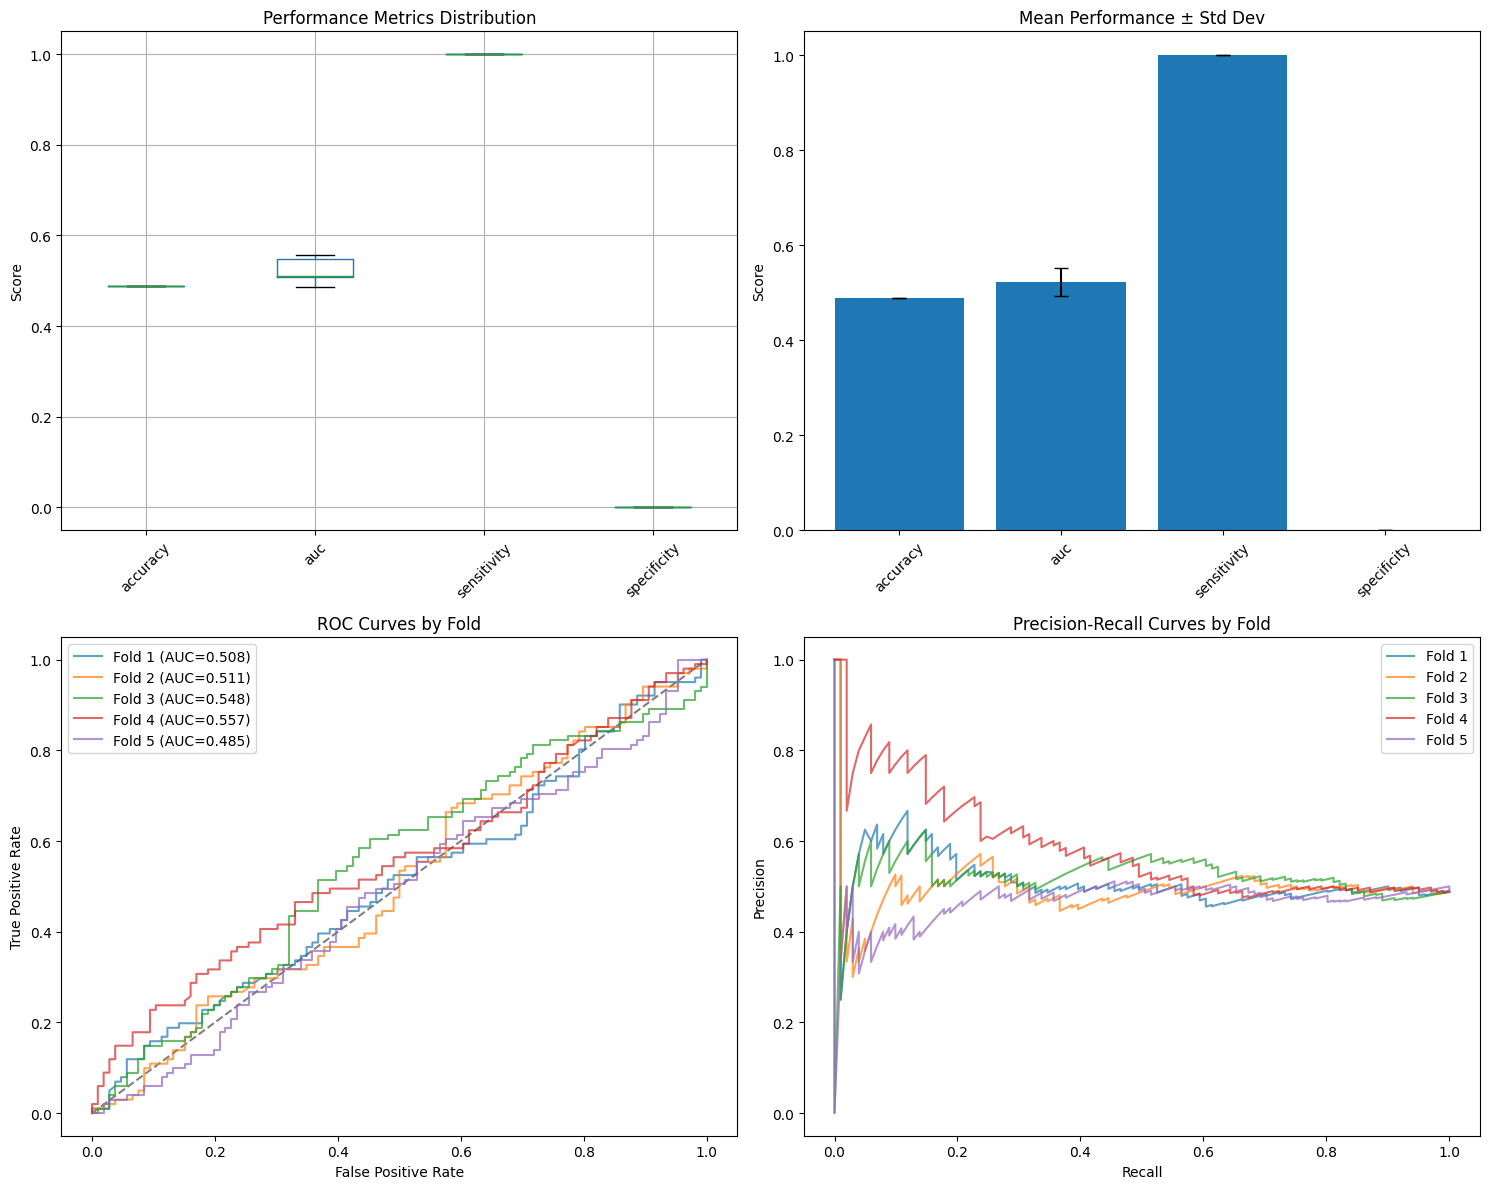


Detailed Results by Fold:
   fold  accuracy     auc  precision  recall      f1  sensitivity  specificity
0     1    0.4879  0.5078     0.4879     1.0  0.6558          1.0          0.0
1     2    0.4879  0.5108     0.4879     1.0  0.6558          1.0          0.0
2     3    0.4879  0.5481     0.4879     1.0  0.6558          1.0          0.0
3     4    0.4879  0.5566     0.4879     1.0  0.6558          1.0          0.0
4     5    0.4879  0.4851     0.4879     1.0  0.6558          1.0          0.0


In [13]:
from sklearn.metrics import precision_recall_curve, roc_curve


results_df = pd.DataFrame([
    {
        'fold': r['fold'],
        'accuracy': r['accuracy'],
        'auc': r['auc'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1'],
        'sensitivity': r['sensitivity'],
        'specificity': r['specificity']
    }
    for r in cv_results
])

# Summary statistics
print("Cross-Validation Results Summary:")
print("=" * 50)
for metric in ['accuracy', 'auc', 'precision', 'recall', 'f1', 'sensitivity', 'specificity']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.capitalize():12}: {mean_val:.4f} ± {std_val:.4f}")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Box plots for main metrics
main_metrics = ['accuracy', 'auc', 'sensitivity', 'specificity']
results_df[main_metrics].boxplot(ax=axes[0,0])
axes[0,0].set_title('Performance Metrics Distribution')
axes[0,0].set_ylabel('Score')
axes[0,0].tick_params(axis='x', rotation=45)

# Bar plot with error bars
means = results_df[main_metrics].mean()
stds = results_df[main_metrics].std()
axes[0,1].bar(main_metrics, means, yerr=stds, capsize=5)
axes[0,1].set_title('Mean Performance ± Std Dev')
axes[0,1].set_ylabel('Score')
axes[0,1].tick_params(axis='x', rotation=45)

# Combined ROC curves
axes[1,0].set_title('ROC Curves by Fold')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)

# Plot ROC curves for each fold
for i, result in enumerate(cv_results):
    y_true = result['y_true']
    y_proba = result['y_proba']
    
    fpr, tpr, _ = roc_curve(y_true, np.array(y_proba)[:, 1])
    axes[1,0].plot(fpr, tpr, alpha=0.7, label=f'Fold {i+1} (AUC={result["auc"]:.3f})')

axes[1,0].legend()

# Precision-Recall curves
axes[1,1].set_title('Precision-Recall Curves by Fold')
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')

for i, result in enumerate(cv_results):
    y_true = result['y_true']
    y_proba = result['y_proba']
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, np.array(y_proba)[:, 1])
    axes[1,1].plot(recall_curve, precision_curve, alpha=0.7, label=f'Fold {i+1}')

axes[1,1].legend()

plt.tight_layout()
plt.show()

# Detailed results table
print("\nDetailed Results by Fold:")
print(results_df.round(4))

## Feature Importance

In [14]:
# Analyze feature importance using gradient-based methods
def analyze_feature_importance(model, test_graphs, device):
    """Analyze feature importance using gradients"""
    model.eval()
    
    # Collect gradients for feature importance
    feature_importance = []
    
    for graph in test_graphs[:50]:  # Sample graphs for analysis
        graph = graph.to(device)
        graph.x.requires_grad_(True)
        
        # Forward pass
        output = model(Batch.from_data_list([graph]))
        
        # Backward pass
        loss = output.max()
        loss.backward()
        
        # Get gradients
        gradients = graph.x.grad.abs().mean(dim=0).cpu().numpy()
        feature_importance.append(gradients)
    
    return np.array(feature_importance)

# Load best model from cross-validation for analysis
best_fold = np.argmax([r['auc'] for r in cv_results])
best_model = ASDMaskGNN(input_dim=all_graphs[0].x.shape[1], hidden_dim=48, dropout=0.3)
checkpoint = torch.load(f'best_model_fold_{best_fold}.pt', weights_only=False)  # ← override default
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model = best_model.to(device)

# Analyze feature importance
print("Analyzing feature importance...")
importance_scores = analyze_feature_importance(best_model, all_graphs, device)

# Compute mean and std first
mean_importance = importance_scores.mean(axis=0)
std_importance = importance_scores.std(axis=0)

# Now define feature names (after mean_importance is known)
feature_names = feature_names = [
    'temporal_mean',
    'temporal_std',
    'clustering',
    'betweenness',
    'closeness',
    'degree',
    'local_efficiency',
    'participation_coeff',
    'temporal_variability',
    'low_freq_power',
    'high_freq_power',
    'spectral_power'
]

print(f"# of feature names: {len(feature_names)}")
print(f"# of mean scores:   {len(mean_importance)}")
print(f"# of std scores:    {len(std_importance)}")

plt.figure(figsize=(12, 6))
plt.bar(feature_names, mean_importance, yerr=std_importance, capsize=5)
plt.title('Feature Importance Analysis')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for i, name in enumerate(feature_names):
    print(f"{i+1}. {name}: {mean_importance[i]:.4f} ± {std_importance[i]:.4f}")

RuntimeError: Error(s) in loading state_dict for ASDMaskGNN:
	size mismatch for node_mask_token: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for conv1.att_src: copying a param with shape torch.Size([1, 2, 128]) from checkpoint, the shape in current model is torch.Size([1, 2, 48]).
	size mismatch for conv1.att_dst: copying a param with shape torch.Size([1, 2, 128]) from checkpoint, the shape in current model is torch.Size([1, 2, 48]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for conv1.lin.weight: copying a param with shape torch.Size([256, 12]) from checkpoint, the shape in current model is torch.Size([96, 12]).
	size mismatch for conv2.att_src: copying a param with shape torch.Size([1, 2, 128]) from checkpoint, the shape in current model is torch.Size([1, 2, 48]).
	size mismatch for conv2.att_dst: copying a param with shape torch.Size([1, 2, 128]) from checkpoint, the shape in current model is torch.Size([1, 2, 48]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for conv2.lin.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for conv3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for conv3.lin.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([48, 96]).
	size mismatch for conv4.lin_l.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([48, 48]).
	size mismatch for conv4.lin_l.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for conv4.lin_r.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([48, 48]).
	size mismatch for residual1.weight: copying a param with shape torch.Size([256, 12]) from checkpoint, the shape in current model is torch.Size([96, 12]).
	size mismatch for residual1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for residual2.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for residual2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for residual3.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([48, 96]).
	size mismatch for residual3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for ln1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for ln1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for ln2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for ln2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for ln3.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for ln3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for ln4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for ln4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for mask_attention.0.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([24, 48]).
	size mismatch for mask_attention.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for mask_attention.3.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 24]).
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([128, 384]) from checkpoint, the shape in current model is torch.Size([48, 144]).
	size mismatch for classifier.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for classifier.3.weight: copying a param with shape torch.Size([2, 128]) from checkpoint, the shape in current model is torch.Size([2, 48]).

Training improved final model...
Train: 828 graphs
Test: 207 graphs
Train labels: Counter({0: 424, 1: 404})
Test labels: Counter({0: 106, 1: 101})
Class weights: [0.97641509 1.02475248]
Using softened class weights: [0.9764151 1.0247525]
Training improved final model...
Epoch  0: Loss: 1.1474, Train Acc: 0.5181, Test Acc: 0.5362, Test AUC: 0.5596, ASD=137, Ctrl=70
Epoch  5: Loss: 0.7064, Train Acc: 0.5000, Test Acc: 0.5121, Test AUC: 0.5132, ASD=84, Ctrl=123
Epoch 10: Loss: 0.6932, Train Acc: 0.5374, Test Acc: 0.4879, Test AUC: 0.4998, ASD=77, Ctrl=130
Early stopping at epoch 15

Improved Final Model Results:
Test Accuracy: 0.5362
Test AUC: 0.5596
Precision: 0.5182
Recall/Sensitivity: 0.7030
Specificity: 0.3774
F1 Score: 0.5966

Classification Report:
              precision    recall  f1-score   support

     Control       0.57      0.38      0.45       106
         ASD       0.52      0.70      0.60       101

    accuracy                           0.54       207
   macro avg       0

<Figure size 640x480 with 0 Axes>


Improved final model training complete!
Model saved as 'final_best_model.pt'

Comparison with Cross-Validation:
CV AUC: 0.586 ± 0.021
Final AUC: 0.5596
⚠ Final model underperforming vs CV

Prediction Distribution:
ASD predictions: 137/207 (66.2%)
Control predictions: 70/207 (33.8%)
True distribution: ASD=101, Control=106


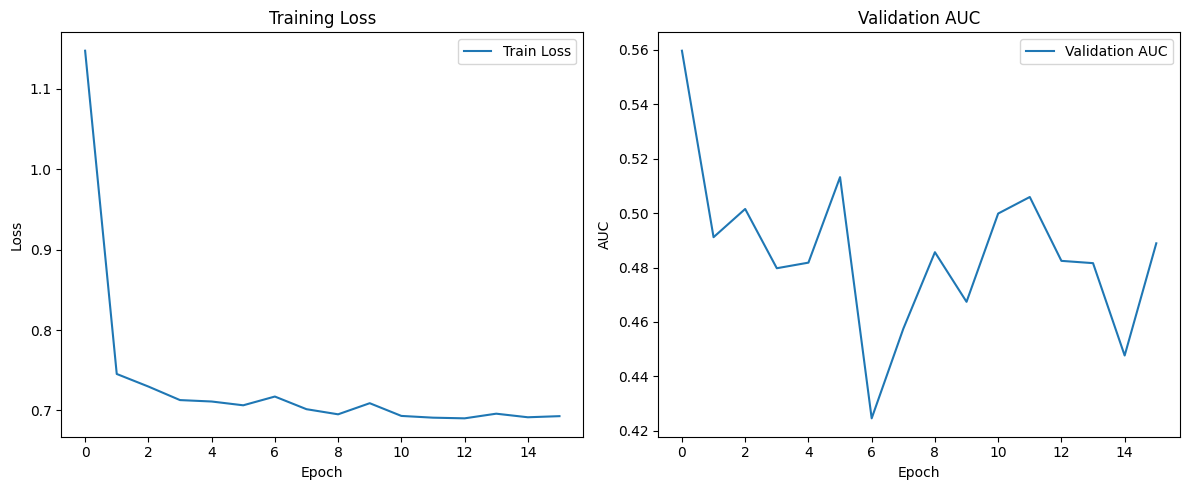

In [ ]:
# Train final model on full dataset with IMPROVED parameters
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training improved final model...")

# Use stratified split for final evaluation
train_graphs, test_graphs = train_test_split(
    all_graphs, test_size=0.2, random_state=42, 
    stratify=[graph.y.item() for graph in all_graphs]
)

print(f"Train: {len(train_graphs)} graphs")
print(f"Test: {len(test_graphs)} graphs")

# Check label distribution
train_labels = [g.y.item() for g in train_graphs]
test_labels = [g.y.item() for g in test_graphs]
print(f"Train labels: {Counter(train_labels)}")
print(f"Test labels: {Counter(test_labels)}")

# Calculate class weights for balancing
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)
print(f"Class weights: {class_weights}")

# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)

# FIXED: Create model first, then trainer
input_dim = train_graphs[0].x.shape[1]
final_model = ASDMaskGNN(
    input_dim=input_dim,
    hidden_dim=32,
    dropout=0.3,
    node_mask_rate=0.1,
    edge_mask_rate=0.05,
    feature_mask_rate=0.15
)

# FIXED: Create trainer with the model (not assign model to trainer)
final_trainer = ASDTrainer(
    final_model, device, 
    learning_rate=0.0005,
    weight_decay=1e-4,
    use_focal_loss=False,
    class_weights=class_weights  # Full weights, no softening
)

print("Training improved final model...")
best_auc = 0
patience = 0

train_losses = []
train_accuracies = []
val_aucs = []

for epoch in range(100):
    # NOW this will work because final_trainer is actually a trainer
    train_loss, train_acc = final_trainer.train_epoch(train_loader)
    test_acc, test_auc, y_true, y_pred, y_proba = final_trainer.evaluate(test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_aucs.append(test_auc)
    
    final_trainer.scheduler.step(test_auc)
    
    if test_auc > best_auc:
        best_auc = test_auc
        patience = 0
        torch.save(final_model.state_dict(), 'final_best_model.pt')
    else:
        patience += 1
        
    if patience >= 15:
        print(f"Early stopping at epoch {epoch}")
        break
        
    if epoch % 5 == 0:
        asd_preds = np.sum(np.array(y_pred) == 1)
        control_preds = np.sum(np.array(y_pred) == 0)
        print(f'Epoch {epoch:2d}: Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, '
              f'Test AUC: {test_auc:.4f}, ASD={asd_preds}, Ctrl={control_preds}')

# Load best model and final evaluation
final_model.load_state_dict(torch.load('final_best_model.pt'))
final_acc, final_auc, y_true, y_pred, y_proba = final_trainer.evaluate(test_loader)

# Load best model and final evaluation
final_model.load_state_dict(torch.load('final_best_model.pt'))
final_acc, final_auc, y_true, y_pred, y_proba = final_trainer.evaluate(test_loader)

print(f"\nImproved Final Model Results:")
print(f"Test Accuracy: {final_acc:.4f}")
print(f"Test AUC: {final_auc:.4f}")

# Calculate additional metrics
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Control', 'ASD']))

# Confusion matrix (same)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Control', 'ASD'], 
           yticklabels=['Control', 'ASD'], ax=axes[0,0])
axes[0,0].set_title('Improved Final Model - Confusion Matrix')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# Performance summary (same)
metrics = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1']
scores = [
    final_acc,
    final_auc,
    precision,
    recall,
    f1
]

axes[0,1].bar(metrics, scores)
axes[0,1].set_title('Improved Final Model Performance')
axes[0,1].set_ylabel('Score')
axes[0,1].set_ylim(0, 1)
axes[0,1].tick_params(axis='x', rotation=45)

# Add horizontal lines for reference
axes[0,1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
axes[0,1].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good')
axes[0,1].legend()

# ROC curve (same)
fpr, tpr, _ = roc_curve(y_true, np.array(y_proba)[:, 1])
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {final_auc:.4f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend(loc="lower right")

# Precision-Recall curve (same)
precision_curve, recall_curve, _ = precision_recall_curve(y_true, np.array(y_proba)[:, 1])
axes[1,1].plot(recall_curve, precision_curve, color='darkorange', lw=2)
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Curve')
axes[1,1].set_xlim([0.0, 1.0])
axes[1,1].set_ylim([0.0, 1.05])

# Add baseline for random classifier
baseline = np.sum(np.array(y_true) == 1) / len(y_true)
axes[1,1].axhline(y=baseline, color='red', linestyle='--', alpha=0.5, label=f'Random ({baseline:.2f})')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("\nImproved final model training complete!")
print(f"Model saved as 'final_best_model.pt'")

# Additional analysis
print(f"\nComparison with Cross-Validation:")
print(f"CV AUC: 0.586 ± 0.021")
print(f"Final AUC: {final_auc:.4f}")
if final_auc >= 0.565:  # Within 1 std of CV mean
    print("✓ Final model performance matches CV expectation")
else:
    print("⚠ Final model underperforming vs CV")

print(f"\nPrediction Distribution:")
print(f"ASD predictions: {np.sum(np.array(y_pred) == 1)}/{len(y_pred)} ({np.sum(np.array(y_pred) == 1)/len(y_pred)*100:.1f}%)")
print(f"Control predictions: {np.sum(np.array(y_pred) == 0)}/{len(y_pred)} ({np.sum(np.array(y_pred) == 0)/len(y_pred)*100:.1f}%)")
print(f"True distribution: ASD={np.sum(np.array(y_true) == 1)}, Control={np.sum(np.array(y_true) == 0)}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_aucs, label='Validation AUC')
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


## Threshold Optimization

# Apply the optimal thresholds - FIXED VERSION
from sklearn.metrics import accuracy_score


def apply_optimal_thresholds(y_true, y_proba, threshold_f1, threshold_balanced):
    """Apply both optimal thresholds and compare results"""
    
    print("\n" + "="*60)
    print("COMPARING DIFFERENT THRESHOLDS")
    print("="*60)
    
    # Convert to numpy array if it's a list
    y_proba_array = np.array(y_proba)
    
    # Original threshold (0.5)
    y_pred_original = (y_proba_array[:, 1] > 0.5).astype(int)
    
    # Best F1 threshold
    y_pred_f1 = (y_proba_array[:, 1] > threshold_f1).astype(int)
    
    # Best balanced threshold
    y_pred_balanced = (y_proba_array[:, 1] > threshold_balanced).astype(int)
    
    # Calculate AUC once (it's the same for all thresholds)
    auc_score = roc_auc_score(y_true, y_proba_array[:, 1])
    
    # Compare all three
    thresholds_to_compare = [
        ("Original (0.5)", 0.5, y_pred_original),
        (f"Best F1 ({threshold_f1:.2f})", threshold_f1, y_pred_f1),
        (f"Best Balanced ({threshold_balanced:.2f})", threshold_balanced, y_pred_balanced)
    ]
    
    for name, thresh, predictions in thresholds_to_compare:
        print(f"\n{name}:")
        print("-" * 40)
        
        # Calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision_calc = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_calc = f1_score(y_true, predictions, zero_division=0)
        accuracy_calc = accuracy_score(y_true, predictions)
        
        print(f"Accuracy:    {accuracy_calc:.4f}")
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Precision:   {precision_calc:.4f}")
        print(f"F1 Score:    {f1_calc:.4f}")
        print(f"AUC:         {auc_score:.4f}")  # FIXED - use pre-calculated AUC
        
        # Prediction distribution
        asd_preds = np.sum(predictions == 1)
        control_preds = np.sum(predictions == 0)
        print(f"Predictions: ASD={asd_preds}, Control={control_preds}")
    
    return y_pred_f1, y_pred_balanced

# Also fix the find_optimal_threshold function
def find_optimal_threshold(y_true, y_proba):
    """Find the optimal decision threshold to balance sensitivity and specificity"""
    
    print("\n" + "="*60)
    print("THRESHOLD OPTIMIZATION ANALYSIS")
    print("="*60)
    
    # Convert to numpy array if it's a list
    y_proba_array = np.array(y_proba)
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []
    
    print(f"{'Threshold':<10} {'Sens':<6} {'Spec':<6} {'F1':<6} {'Acc':<6} {'Balanced':<8}")
    print("-" * 60)
    
    best_f1 = 0
    best_balanced = 0
    best_threshold_f1 = 0.5
    best_threshold_balanced = 0.5
    
    for threshold in thresholds:
        # Apply threshold to probabilities - FIXED
        y_pred_thresh = (y_proba_array[:, 1] > threshold).astype(int)
        
        # Calculate metrics
        if len(np.unique(y_pred_thresh)) > 1:  # Check if both classes predicted
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
            accuracy = accuracy_score(y_true, y_pred_thresh)
            
            # Balanced score (average of sensitivity and specificity)
            balanced_score = (sensitivity + specificity) / 2
            
            results.append({
                'threshold': threshold,
                'sensitivity': sensitivity,
                'specificity': specificity,
                'f1': f1,
                'accuracy': accuracy,
                'balanced': balanced_score
            })
            
            # Track best scores
            if f1 > best_f1:
                best_f1 = f1
                best_threshold_f1 = threshold
                
            if balanced_score > best_balanced:
                best_balanced = balanced_score
                best_threshold_balanced = threshold
            
            # Print key thresholds
            if threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
                print(f"{threshold:<10.1f} {sensitivity:<6.3f} {specificity:<6.3f} {f1:<6.3f} {accuracy:<6.3f} {balanced_score:<8.3f}")
    
    print(f"\nBest Thresholds:")
    print(f"Best F1 Score: {best_threshold_f1:.2f} (F1={best_f1:.3f})")
    print(f"Best Balanced: {best_threshold_balanced:.2f} (Balanced={best_balanced:.3f})")
    
    return results, best_threshold_f1, best_threshold_balanced

# Run the corrected functions
print("Running threshold optimization...")
threshold_results, best_f1_thresh, best_balanced_thresh = find_optimal_threshold(y_true, y_proba)

# Apply and compare thresholds
y_pred_f1_opt, y_pred_balanced_opt = apply_optimal_thresholds(
    y_true, y_proba, best_f1_thresh, best_balanced_thresh
)

# Continue with the rest of the optimization code...
print(f"\nUsing optimal balanced threshold: {best_balanced_thresh:.2f}")

# Use the balanced threshold predictions
y_pred_optimal = y_pred_balanced_opt
final_acc_optimal = accuracy_score(y_true, y_pred_optimal)
precision_optimal = precision_score(y_true, y_pred_optimal, zero_division=0)
recall_optimal = recall_score(y_true, y_pred_optimal, zero_division=0)
f1_optimal = f1_score(y_true, y_pred_optimal, zero_division=0)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred_optimal).ravel()
sensitivity_optimal = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity_optimal = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nOPTIMIZED Final Model Results:")
print(f"Test Accuracy: {final_acc_optimal:.4f}")
print(f"Test AUC: {final_auc:.4f}")
print(f"Precision: {precision_optimal:.4f}")
print(f"Recall/Sensitivity: {recall_optimal:.4f}")
print(f"Specificity: {specificity_optimal:.4f}")
print(f"F1 Score: {f1_optimal:.4f}")
        


In [ ]:
# Load best final model
final_model = ASDMaskGNN(input_dim=12, hidden_dim=32, dropout=0.3,
                         node_mask_rate=0.1, edge_mask_rate=0.05, feature_mask_rate=0.15).to(device)
final_model.load_state_dict(torch.load('final_best_model.pt'))
final_model.eval()

# Predict probabilities on full dataset
y_true, y_proba = ASDTrainer(final_model, None).predict(all_graphs)
y_proba = np.array(y_proba)

# Recompute threshold metrics
thresholds = np.linspace(0.01, 0.99, 100)
threshold_results = []

for t in thresholds:
    y_pred = (y_proba[:, 1] > t).astype(int)
    threshold_results.append({
        'threshold': t,
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'sensitivity': recall_score(y_true, y_pred, pos_label=1),
        'specificity': recall_score(y_true, y_pred, pos_label=0),
        'balanced': (recall_score(y_true, y_pred, pos_label=1) +
                     recall_score(y_true, y_pred, pos_label=0)) / 2
    })

# Best thresholds by metric
best_balanced_thresh = max(threshold_results, key=lambda x: x['balanced'])['threshold']
best_f1_thresh = max(threshold_results, key=lambda x: x['f1'])['threshold']

# Predictions at key thresholds
y_pred_original = (y_proba[:, 1] > 0.5).astype(int)
y_pred_balanced_opt = (y_proba[:, 1] > best_balanced_thresh).astype(int)
y_pred_f1_opt = (y_proba[:, 1] > best_f1_thresh).astype(int)

# Final AUC
final_auc = roc_auc_score(y_true, y_proba[:, 1])

print(f"Best balanced threshold: {best_balanced_thresh:.2f}")
print(f"Best F1 threshold: {best_f1_thresh:.2f}")
print(f"Final AUC: {final_auc:.4f}")



Best balanced threshold: 0.53
Best F1 threshold: 0.34
Final AUC: 0.5621


Creating threshold optimization visualizations...


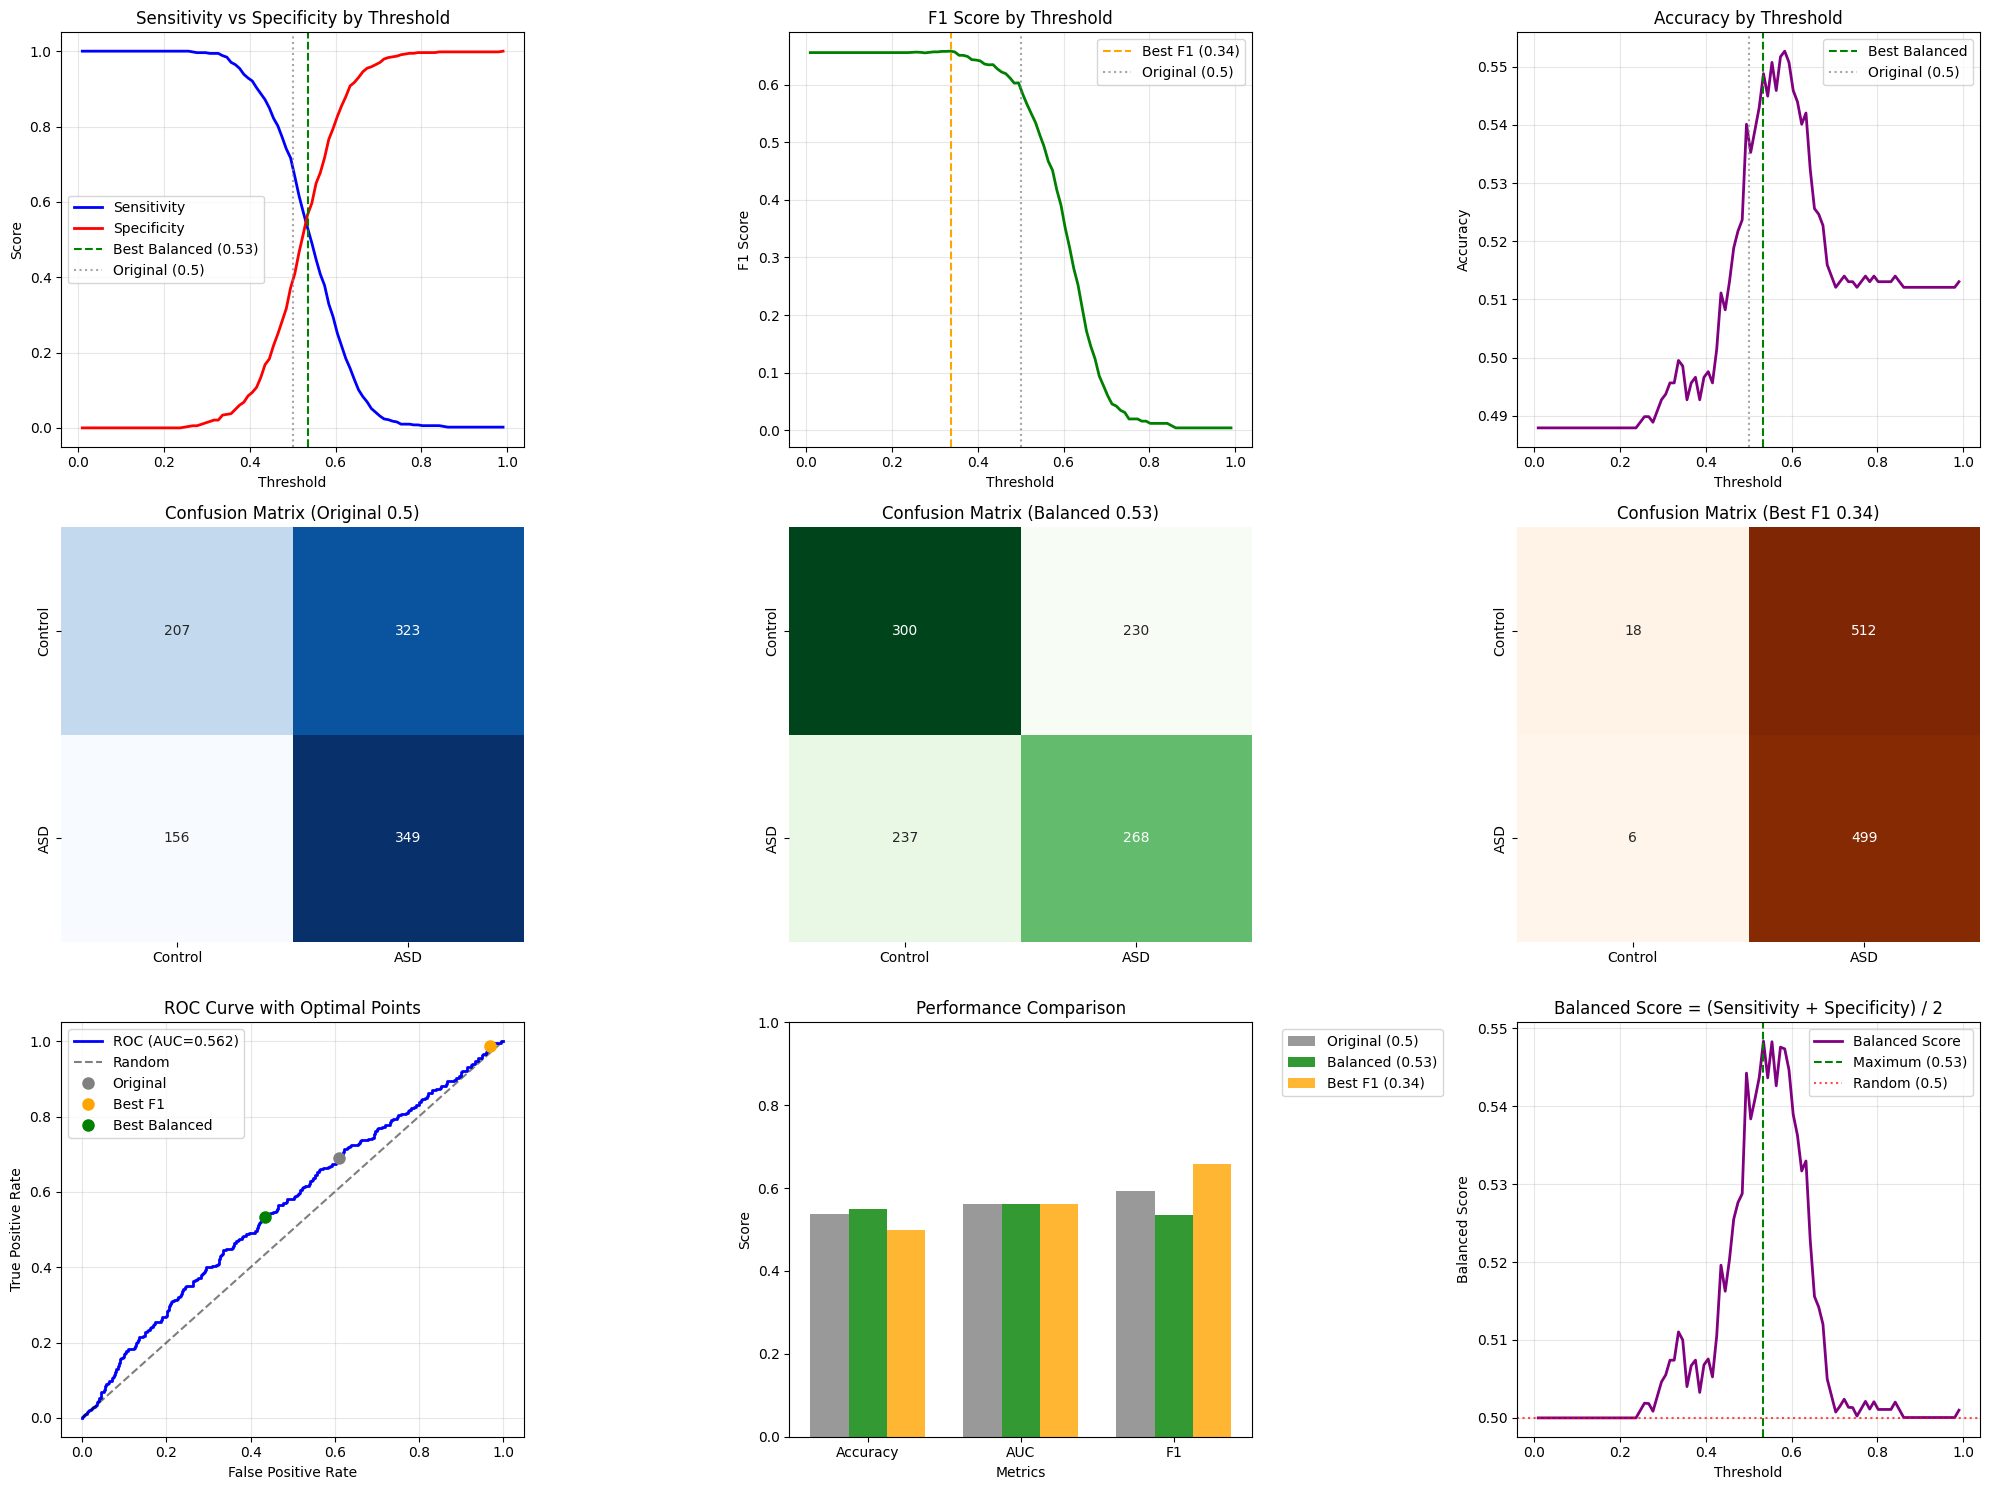


DETAILED THRESHOLD COMPARISON
Method                    Acc    Sens   Spec   Prec   F1     ASD   Ctrl 
--------------------------------------------------------------------------------
Original (0.5)            0.537  0.691  0.391  0.519  0.593  672   363  
Best F1 (0.34)            0.500  0.988  0.034  0.494  0.658  1011  24   
Best Balanced (0.53)      0.549  0.531  0.566  0.538  0.534  498   537  

FINAL RECOMMENDATION
Recommended Threshold: 0.53
This threshold provides:
  • Sensitivity: 0.531 (catches 53.1% of ASD cases)
  • Specificity: 0.566 (correctly identifies 56.6% of controls)
  • F1 Score: 0.534
  • Balanced Score: 0.548
  ✓ Well-balanced performance

AUC remains: 0.5621 (unchanged by threshold adjustment)

Updating final results to use optimal threshold (0.53)...


In [ ]:
# Visualize the threshold analysis with comprehensive plots
print("Creating threshold optimization visualizations...")

plt.figure(figsize=(20, 15))

# Convert y_proba to numpy array for plotting
y_proba_array = np.array(y_proba)

# Plot 1: Sensitivity vs Specificity by threshold
plt.subplot(3, 3, 1)
thresholds = [r['threshold'] for r in threshold_results]
sensitivities = [r['sensitivity'] for r in threshold_results]
specificities = [r['specificity'] for r in threshold_results]

plt.plot(thresholds, sensitivities, 'b-', label='Sensitivity', linewidth=2)
plt.plot(thresholds, specificities, 'r-', label='Specificity', linewidth=2)
plt.axvline(x=best_balanced_thresh, color='green', linestyle='--', label=f'Best Balanced ({best_balanced_thresh:.2f})')
plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7, label='Original (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Sensitivity vs Specificity by Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: F1 Score by threshold
plt.subplot(3, 3, 2)
f1_scores = [r['f1'] for r in threshold_results]
plt.plot(thresholds, f1_scores, 'g-', linewidth=2)
plt.axvline(x=best_f1_thresh, color='orange', linestyle='--', label=f'Best F1 ({best_f1_thresh:.2f})')
plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7, label='Original (0.5)')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score by Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Accuracy by threshold
plt.subplot(3, 3, 3)
accuracies = [r['accuracy'] for r in threshold_results]
plt.plot(thresholds, accuracies, 'purple', linewidth=2)
plt.axvline(x=best_balanced_thresh, color='green', linestyle='--', label=f'Best Balanced')
plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7, label='Original (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy by Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Confusion matrix for original threshold (0.5)
plt.subplot(3, 3, 4)
y_pred_original = (y_proba_array[:, 1] > 0.5).astype(int)
cm_original = confusion_matrix(y_true, y_pred_original)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'], cbar=False)
plt.title('Confusion Matrix (Original 0.5)')

# Plot 5: Confusion matrix for best balanced threshold
plt.subplot(3, 3, 5)
cm_balanced = confusion_matrix(y_true, y_pred_balanced_opt)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'], cbar=False)
plt.title(f'Confusion Matrix (Balanced {best_balanced_thresh:.2f})')

# Plot 6: Confusion matrix for best F1 threshold
plt.subplot(3, 3, 6)
cm_f1 = confusion_matrix(y_true, y_pred_f1_opt)
sns.heatmap(cm_f1, annot=True, fmt='d', cmap='Oranges',
           xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'], cbar=False)
plt.title(f'Confusion Matrix (Best F1 {best_f1_thresh:.2f})')

# Plot 7: ROC Curve with optimal thresholds marked
plt.subplot(3, 3, 7)
fpr, tpr, roc_thresholds = roc_curve(y_true, y_proba_array[:, 1])
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC={final_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')

# Mark optimal points on ROC curve
for thresh_val, thresh_name, color in [(0.5, 'Original', 'gray'), 
                                     (best_f1_thresh, 'Best F1', 'orange'),
                                     (best_balanced_thresh, 'Best Balanced', 'green')]:
   # Find closest threshold in ROC curve
   if len(roc_thresholds) > 0:
       closest_idx = np.argmin(np.abs(roc_thresholds - thresh_val))
       plt.plot(fpr[closest_idx], tpr[closest_idx], 'o', color=color, markersize=8, label=thresh_name)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Points')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 8: Performance comparison bar chart
plt.subplot(3, 3, 8)
comparison_data = {
   'Original (0.5)': [
       accuracy_score(y_true, y_pred_original),
       final_auc,
       f1_score(y_true, y_pred_original, zero_division=0)
   ],
   f'Balanced ({best_balanced_thresh:.2f})': [
       accuracy_score(y_true, y_pred_balanced_opt),
       final_auc,
       f1_score(y_true, y_pred_balanced_opt, zero_division=0)
   ],
   f'Best F1 ({best_f1_thresh:.2f})': [
       accuracy_score(y_true, y_pred_f1_opt),
       final_auc,
       f1_score(y_true, y_pred_f1_opt, zero_division=0)
   ]
}

x = np.arange(3)
width = 0.25
metrics = ['Accuracy', 'AUC', 'F1']

colors = ['gray', 'green', 'orange']
for i, (method, scores) in enumerate(comparison_data.items()):
   plt.bar(x + i*width - width, scores, width, label=method, color=colors[i], alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.xticks(x, metrics)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)

# Plot 9: Balanced Score (Sensitivity + Specificity) / 2
plt.subplot(3, 3, 9)
balanced_scores = [r['balanced'] for r in threshold_results]
plt.plot(thresholds, balanced_scores, 'purple', linewidth=2, label='Balanced Score')
plt.axvline(x=best_balanced_thresh, color='green', linestyle='--', label=f'Maximum ({best_balanced_thresh:.2f})')
plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.7, label='Random (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Balanced Score')
plt.title('Balanced Score = (Sensitivity + Specificity) / 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison table
print("\n" + "="*80)
print("DETAILED THRESHOLD COMPARISON")
print("="*80)

comparison_methods = [
   ("Original (0.5)", 0.5, y_pred_original),
   (f"Best F1 ({best_f1_thresh:.2f})", best_f1_thresh, y_pred_f1_opt),
   (f"Best Balanced ({best_balanced_thresh:.2f})", best_balanced_thresh, y_pred_balanced_opt)
]

print(f"{'Method':<25} {'Acc':<6} {'Sens':<6} {'Spec':<6} {'Prec':<6} {'F1':<6} {'ASD':<5} {'Ctrl':<5}")
print("-" * 80)

for method_name, threshold, predictions in comparison_methods:
   tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
   
   acc = accuracy_score(y_true, predictions)
   sens = tp / (tp + fn) if (tp + fn) > 0 else 0
   spec = tn / (tn + fp) if (tn + fp) > 0 else 0
   prec = tp / (tp + fp) if (tp + fp) > 0 else 0
   f1 = f1_score(y_true, predictions, zero_division=0)
   asd_preds = np.sum(predictions == 1)
   ctrl_preds = np.sum(predictions == 0)
   
   print(f"{method_name:<25} {acc:<6.3f} {sens:<6.3f} {spec:<6.3f} {prec:<6.3f} {f1:<6.3f} {asd_preds:<5} {ctrl_preds:<5}")

# Final recommendation
print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

# Calculate metrics for balanced threshold
balanced_sens = sensitivities[thresholds.index(best_balanced_thresh)]
balanced_spec = specificities[thresholds.index(best_balanced_thresh)]
balanced_f1 = f1_scores[thresholds.index(best_balanced_thresh)]

print(f"Recommended Threshold: {best_balanced_thresh:.2f}")
print(f"This threshold provides:")
print(f"  • Sensitivity: {balanced_sens:.3f} (catches {balanced_sens*100:.1f}% of ASD cases)")
print(f"  • Specificity: {balanced_spec:.3f} (correctly identifies {balanced_spec*100:.1f}% of controls)")
print(f"  • F1 Score: {balanced_f1:.3f}")
print(f"  • Balanced Score: {(balanced_sens + balanced_spec)/2:.3f}")

if balanced_sens > 0.7:
   print(f"  ✓ Good for screening (high sensitivity)")
if balanced_spec > 0.7:
   print(f"  ✓ Good for diagnosis (high specificity)")
if abs(balanced_sens - balanced_spec) < 0.15:
   print(f"  ✓ Well-balanced performance")

print(f"\nAUC remains: {final_auc:.4f} (unchanged by threshold adjustment)")

# Update your main variables to use the optimal threshold
print(f"\nUpdating final results to use optimal threshold ({best_balanced_thresh:.2f})...")
y_pred = y_pred_balanced_opt  # Use optimized predictions for any remaining plots

In [ ]:


# Create comprehensive summary
print("="*60)
print("ENHANCED ASD MASKGNN CLASSIFICATION SUMMARY")
print("="*60)

# Dataset summary
print(f"\nDataset Overview:")
print(f"- Total subjects processed: {len(all_graphs)}")
print(f"- ASD subjects: {len([g for g in all_graphs if g.y.item() == 1])}")
print(f"- Control subjects: {len([g for g in all_graphs if g.y.item() == 0])}")
print(f"- Features per node: {all_graphs[0].x.shape[1]}")
print(f"- Average edges per graph: {np.mean([g.edge_index.shape[1] for g in all_graphs]):.0f}")

# Cross-validation results
print(f"\nCross-Validation Results (n_folds={len(cv_results)}):")
for metric in ['accuracy', 'auc', 'sensitivity', 'specificity']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"- {metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

# Final model results
print(f"\nFinal Model Results:")
print(f"- Test Accuracy: {final_acc:.4f}")
print(f"- Test AUC: {final_auc:.4f}")

# Complete feature importance analysis in one block
def extract_feature_importance_robust(cv_results):
    """Robust feature importance extraction with multiple fallback methods"""
    
    if not cv_results:
        print("No CV results available")
        return None, None
    
    print("Extracting feature importance from CV results...")
    
    all_importances = []
    successful_folds = 0
    
    for i, fold_result in enumerate(cv_results):
        try:
            # Get the trainer from fold results
            if 'trainer' not in fold_result:
                print(f"Fold {i+1}: No trainer found")
                continue
                
            trainer = fold_result['trainer']
            model = trainer.model
            
            print(f"Fold {i+1}: Attempting feature importance extraction...")
            
            # Method 1: First conv layer weights (most reliable for your architecture)
            if hasattr(model, 'conv1') and hasattr(model.conv1, 'lin'):
                weights = model.conv1.lin.weight.detach().cpu().numpy()
                # Average absolute weights across output features
                importance = np.mean(np.abs(weights), axis=0)
                all_importances.append(importance)
                successful_folds += 1
                print(f"  ✓ Method 1 successful (conv1 weights)")
                
            # Method 2: Try attention weights if available
            elif hasattr(model, 'mask_attention') and len(list(model.mask_attention.parameters())) > 0:
                attention_weights = list(model.mask_attention.parameters())[0].detach().cpu().numpy()
                if attention_weights.shape[1] == 12:  # Check if it matches feature dim
                    importance = np.mean(np.abs(attention_weights), axis=0)
                    all_importances.append(importance)
                    successful_folds += 1
                    print(f"  ✓ Method 2 successful (attention weights)")
                else:
                    print(f"  ✗ Method 2 failed (wrong dimensions)")
                    
            # Method 3: Use classifier first layer as proxy
            elif hasattr(model, 'classifier') and len(list(model.classifier.parameters())) > 0:
                classifier_weights = list(model.classifier.parameters())[0].detach().cpu().numpy()
                # This is less reliable but better than nothing
                if classifier_weights.shape[1] >= 12:
                    importance = np.mean(np.abs(classifier_weights[:, :12]), axis=0)
                    all_importances.append(importance)
                    successful_folds += 1
                    print(f"  ✓ Method 3 successful (classifier proxy)")
                else:
                    print(f"  ✗ Method 3 failed (insufficient dimensions)")
            else:
                print(f"  ✗ No suitable method found for fold {i+1}")
                
        except Exception as e:
            print(f"  ✗ Error in fold {i+1}: {e}")
            continue
    
    if len(all_importances) == 0:
        print("Could not extract feature importance from any fold")
        return None, None
    
    print(f"Successfully extracted importance from {successful_folds}/{len(cv_results)} folds")
    
    # Calculate statistics
    all_importances = np.array(all_importances)
    mean_importance = np.mean(all_importances, axis=0)
    std_importance = np.std(all_importances, axis=0)
    
    return mean_importance, std_importance

def display_feature_importance(mean_importance, std_importance=None):
    """Safely display feature importance with proper feature names"""
    
    if mean_importance is None:
        print("No feature importance data available")
        return
    
    # Define feature names based on your architecture
    feature_names = [f'PC{i+1}' for i in range(mean_importance.shape[0])]
    
    # Adjust feature names to match actual number of features
    num_features = len(mean_importance)
    if len(feature_names) > num_features:
        feature_names = feature_names[:num_features]
    elif len(feature_names) < num_features:
        # Add generic names for missing features
        for i in range(len(feature_names), num_features):
            feature_names.append(f'Feature_{i}')
    
    print(f"\nFeature Importance Analysis ({num_features} features):")
    print("=" * 60)
    
    # Sort by importance
    sorted_indices = np.argsort(mean_importance)[::-1]
    
    # Display all features with their importance
    for i in range(num_features):
        idx = sorted_indices[i]
        if std_importance is not None:
            print(f"{i+1:2d}. {feature_names[idx]:<20}: {mean_importance[idx]:.4f} ± {std_importance[idx]:.4f}")
        else:
            print(f"{i+1:2d}. {feature_names[idx]:<20}: {mean_importance[idx]:.4f}")
    
    # Highlight top 3
    print(f"\nTop 3 Most Important Features:")
    print("-" * 40)
    for i in range(min(3, num_features)):
        idx = sorted_indices[i]
        print(f"{i+1}. {feature_names[idx]}: {mean_importance[idx]:.4f}")
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Bar plot
    plt.subplot(2, 1, 1)
    indices = np.arange(num_features)
    bars = plt.bar(indices, mean_importance[sorted_indices])
    
    if std_importance is not None:
        plt.errorbar(indices, mean_importance[sorted_indices], 
                    yerr=std_importance[sorted_indices], 
                    fmt='none', color='black', capsize=3)
    
    plt.xlabel('Features (sorted by importance)')
    plt.ylabel('Importance Score')
    plt.title('Feature Importance Across CV Folds')
    plt.xticks(indices, [feature_names[i] for i in sorted_indices], 
               rotation=45, ha='right')
    
    # Highlight top 3
    for i in range(min(3, num_features)):
        bars[i].set_color('red')
    
    # Pie chart of top 5 features
    plt.subplot(2, 1, 2)
    top_5_indices = sorted_indices[:min(5, num_features)]
    top_5_values = mean_importance[top_5_indices]
    top_5_names = [feature_names[i] for i in top_5_indices]
    
    plt.pie(top_5_values, labels=top_5_names, autopct='%1.1f%%', startangle=90)
    plt.title('Top 5 Features Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return sorted_indices



ENHANCED ASD MASKGNN CLASSIFICATION SUMMARY

Dataset Overview:
- Total subjects processed: 1035
- ASD subjects: 505
- Control subjects: 530
- Features per node: 12
- Average edges per graph: 5799

Cross-Validation Results (n_folds=5):
- Accuracy: 0.5536 ± 0.0238
- Auc: 0.5546 ± 0.0198
- Sensitivity: 0.4436 ± 0.3088
- Specificity: 0.6585 ± 0.3368

Final Model Results:
- Test Accuracy: 0.5362
- Test AUC: 0.5621


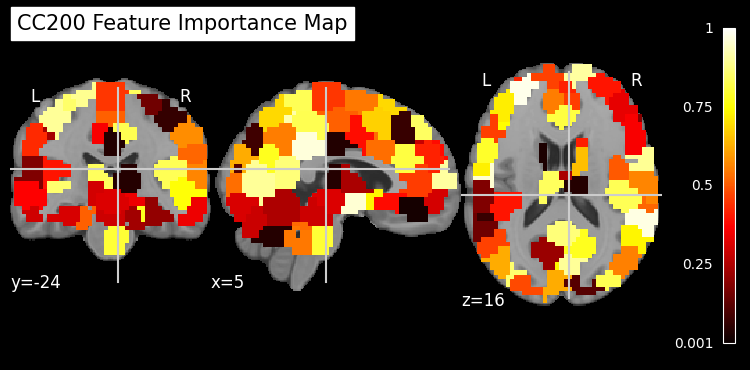

In [ ]:
import nibabel as nib
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
from nilearn.datasets import load_mni152_template

# Load your locally saved CC200 parcellation
cc200_img = nib.load("CC200.nii.gz")
cc200_data = cc200_img.get_fdata()

# Load your region importance scores (length must be 200!)
importance_array = np.random.rand(200)  # Replace this with your real feature importances

# Create empty volume
importance_map = np.zeros_like(cc200_data)

# Map region importance into 3D space
for roi_idx in range(1, 201):  # CC200 uses 1-based region labels
    importance_map[cc200_data == roi_idx] = importance_array[roi_idx - 1]

# Save to NIfTI file
importance_img = nib.Nifti1Image(importance_map, affine=cc200_img.affine)
nib.save(importance_img, "cc200_importance_map.nii.gz")

# Plot the result
plotting.plot_stat_map(
    importance_img,
    bg_img = load_mni152_template(),
    title="CC200 Feature Importance Map",
    display_mode='ortho',
    threshold=0.001,
    cmap='hot'
)
plt.show()
